<small><i>This notebook was put together by [Volha Hedranovich](http://www.rocketscience.ai) and [Alexander Fridman](http://www.rocketscience.ai) for the Lecture Course. Source and license info is on [GitHub](https://github.com/volhahedranovich/jupyter_lectures).

Based on the module [sklearn.cluster](http://scikit-learn.org/stable/modules/clustering.html#clustering).</i></small>

# Comparing different clustering algorithms on toy datasets

First do initial imports.

In [4]:
%matplotlib inline

import time
import warnings
from itertools import cycle, islice

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skl_datasets

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from ipywidgets import HTML

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.



In [2]:
HTML('<img src="data/scikit-learn_clustering.png">')

## Generate datasets

We choose the size big enough to see the scalability of the algorithms, but not too big to avoid too long running times.

In [5]:
np.random.seed(12)

n_samples = 1500
noisy_circles = skl_datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = skl_datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = skl_datasets.make_blobs(n_samples=n_samples, random_state=8, cluster_std=2)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = skl_datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = skl_datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

## Visualize initial datasets

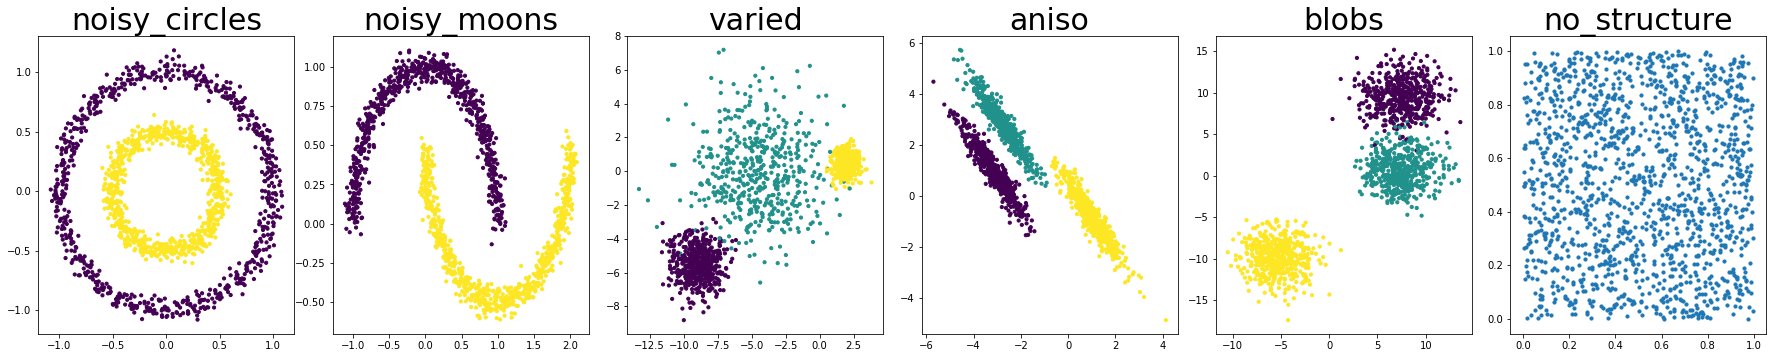

In [6]:
datasets_init = [noisy_circles, noisy_moons, varied,
                 aniso, blobs, no_structure]
datasets_init_names = ["noisy_circles", "noisy_moons",
                       "varied", "aniso", "blobs", "no_structure"]

plt.figure(figsize=(25, 25))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.15)

plot_num = 1

for (dataset_X, dataset_y), dataset_name in zip(datasets_init, datasets_init_names):
    plt.subplot(5, 6, plot_num)
    plt.title(dataset_name, size=30, horizontalalignment='center')
    plt.scatter(dataset_X[:, 0], dataset_X[:, 1], s=10, c=dataset_y)
    plot_num += 1

## Set up cluster parameters

In [7]:
default_base = {
    'quantile': .3,
    'eps': .3,
    'damping': .9,
    'preference': -200,
    'n_neighbors': 10,
    'n_clusters': 3
}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})
]

## Clustering and visualizing

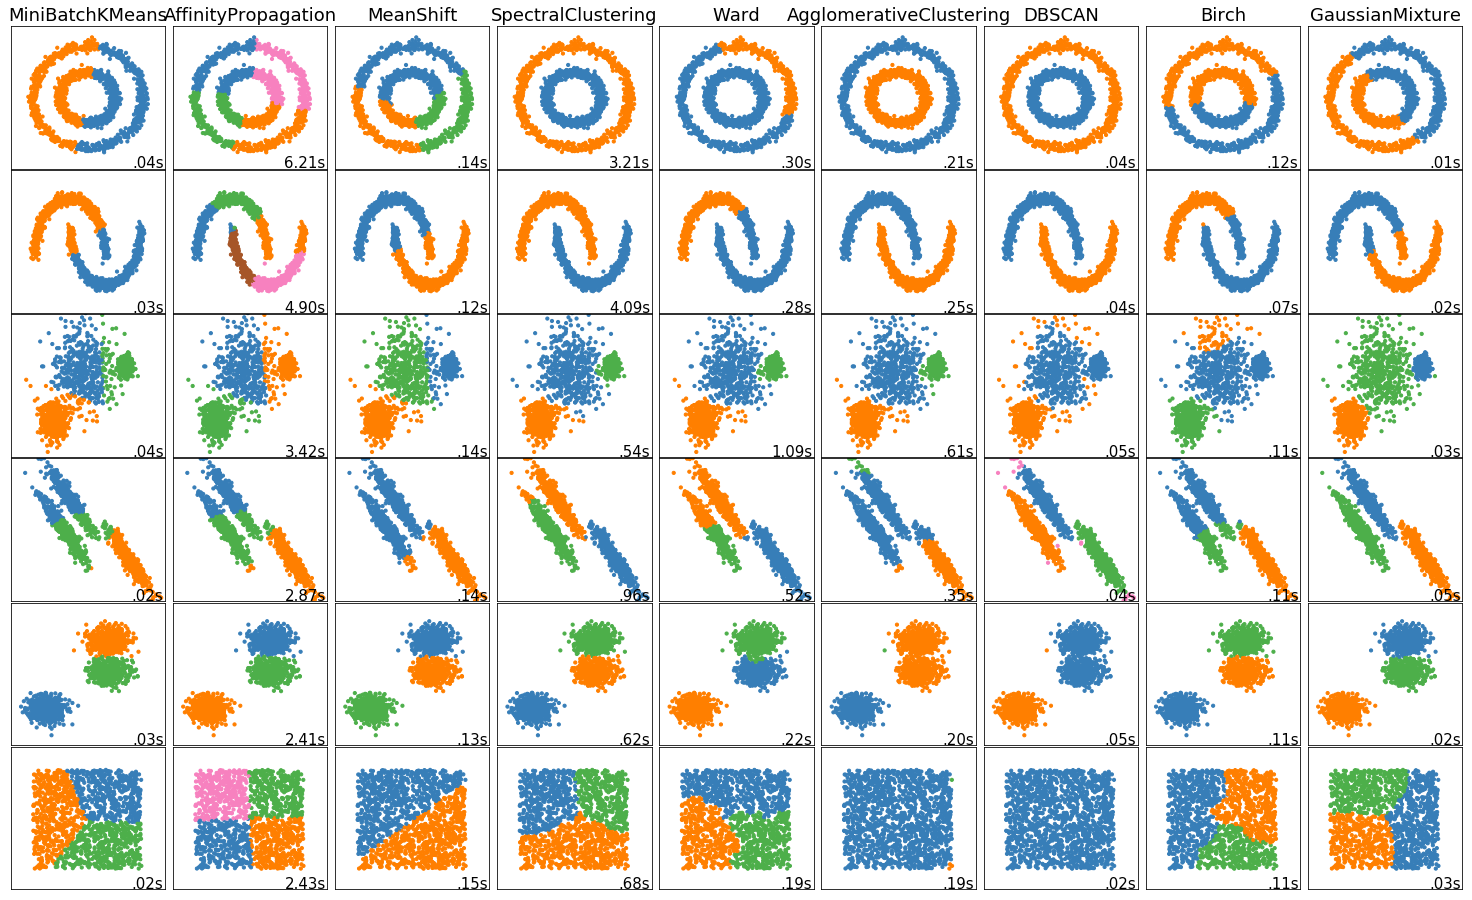

In [8]:
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, ((X, y), algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for MeanShift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

# Try different parameters for an algorithm

Let's create a function, which runs one clustering method with different parameters on each dataset.

In [9]:
def cluster_dif_params(algorithm, param_combinations):
    plt.figure(figsize=(len(param_combinations) * 2 + 2, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    plot_num = 1
    for i_dataset, ((X, y), dataset_params) in enumerate(datasets):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(dataset_params)

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        for i, param_comb in enumerate(param_combinations):
            params_i = params.copy()
            params_i.update(param_comb)
            params_i = {k: params_i[k] for k in algorithm._get_param_names() if k in params_i}

            model = algorithm(**params_i)
            model.fit(X)

            if hasattr(algorithm, 'labels_'):
                y_pred = model.labels_.astype(np.int)
            else:
                y_pred = model.predict(X)

            plt.subplot(len(datasets), len(param_combinations), plot_num)
            if i_dataset == 0:
                plt.title('param comb {}'.format(i + 1), size=18)

            colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                 '#f781bf', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
            plt.scatter(X[:, 0], X[:, 1], s=7, color=colors[y_pred])

            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plot_num += 1

Now we can choose one clustering method and run it with multiple sets of parameters (up to 9 combinations).

## <font color=red>Homework<font color=red>

Explore all clustering algorithms provided in scikit-learn. Discover the influence of methods' parameters on its performance using the function **cluster_dif_params**.

```python
    algorithm = cluster.MiniBatchKMeans
    param_combinations = [
        {'max_iter': 100, 'batch_size': 100},
        {'max_iter': 1000, 'batch_size': 100, 'n_clusters': 2},
        {'max_iter': 1000, 'batch_size': 10, 'n_clusters': 4},
    ]
    
    cluster_dif_params(algorithm, param_combinations)
```

Feel free to change dataset generation parameters in the block **Generate datasets** above.

[sklearn.cluster user guide](http://scikit-learn.org/stable/modules/classes.html#classes)

### Example

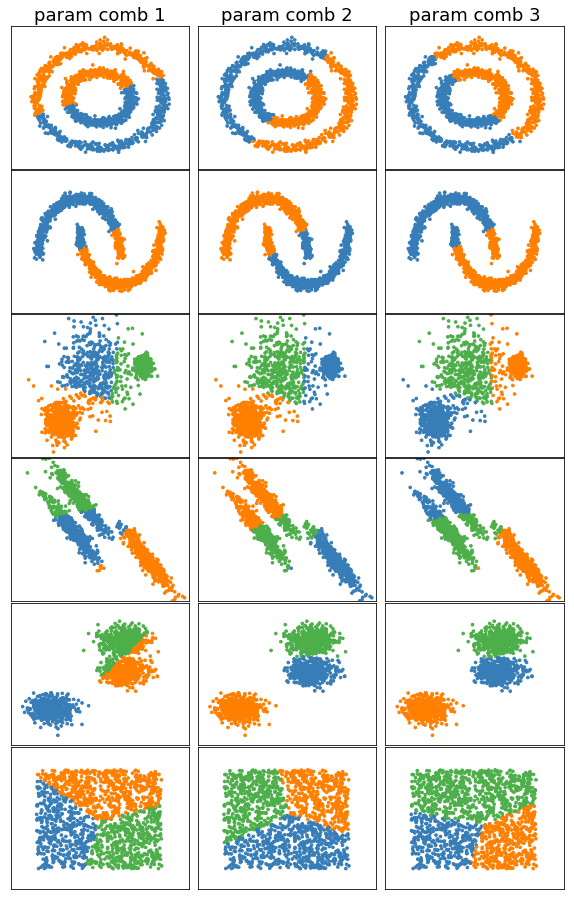

In [10]:
algorithm = cluster.MiniBatchKMeans
param_combinations = [
    {'max_iter': 2, 'batch_size': 3, 'init': 'random'},
    {'max_iter': 10, 'batch_size': 3, 'init': 'random'},
    {'max_iter': 100, 'batch_size': 3, 'init': 'random'},
]

cluster_dif_params(algorithm, param_combinations)